In [440]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.optim as optim
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split, Subset, DataLoader
from collections import Counter

torch.manual_seed(265)
torch.set_default_dtype(torch.double)

In [441]:
data_cifar10 = datasets.CIFAR10(
            '../data/',             
            download=True)

Files already downloaded and verified


In [442]:
#The cifar train dataset
data_cifar10

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../data/
    Split: Train

In [443]:
#The distribution of the train dataset
np.unique(data_cifar10.targets, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000],
       dtype=int64))

In [444]:
data_cifar10[0]

(<PIL.Image.Image image mode=RGB size=32x32>, 6)

In [445]:
data_cifar10.data[0].shape

(32, 32, 3)

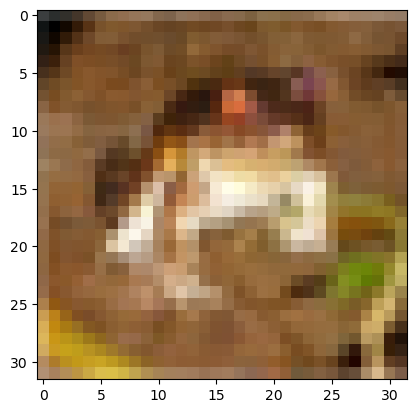

In [446]:
plt.imshow(data_cifar10[0][0])

In [447]:
data_cifar10.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

The first datapoint is a PIL image with size 32x32 and target 6. It should resemble a frog. Borrowing code from the examples to showcase what all the targets looks like.

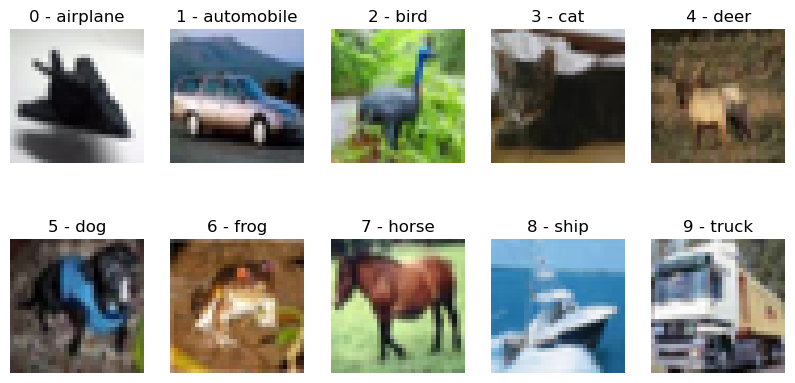

In [448]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10,5))

for i, ax in enumerate(axes.flat):
    img = next(img for img, label in data_cifar10 if label == i)
    ax.imshow(img, cmap='gray')
    ax.set_title(f'{i} - {data_cifar10.classes[i]}')
    ax.axis('off')
    
plt.show()

In [449]:
print('Should we normalize?\n')
data = data_cifar10.data /255
data_mean = data.mean(axis=(0,1,2))
data_std = data.std(axis=(0,1,2))
data_var = data.var(axis=(0,1,2))

print('mean: ' , data_mean)
print('std' , data_std)
print('variance' , data_var)


print('\nYes')

Should we normalize?

mean:  [0.49139968 0.48215841 0.44653091]
std [0.24703223 0.24348513 0.26158784]
variance [0.06102492 0.05928501 0.0684282 ]

Yes


Normalization is generally a good idea. It can improve performance. Therefore we should now transform the data with normalization and make it usable for pytorch by turning them to tensors.

In [450]:
preprocessor = transforms.Compose([ 
    transforms.ToTensor(),
    transforms.Normalize(mean=data_mean, std = data_std)
])

In [451]:
def load_cifar10(train_val_ratio, datapath='../data/'):
    
    data_train_val = datasets.CIFAR10(
            datapath,       
            train=True,      
            download=True,
            transform = preprocessor
    )

    
    data_test = datasets.CIFAR10(
        datapath, 
        train=False,
        download=True,
        transform = preprocessor
    )


    n_train = int(len(data_train_val)*train_val_ratio)
    n_val =  len(data_train_val) - n_train
    
    data_train, data_val = random_split(
        data_train_val, 
        [n_train, n_val],
        generator=torch.Generator().manual_seed(265)
    )
    
    return data_train, data_val, data_test

In [452]:
data_train, data_val, data_test = load_cifar10(0.9)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


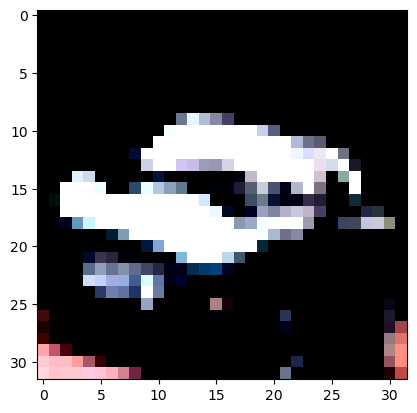

In [453]:
#How the image looks after normalization
plt.imshow(data_train[0][0].permute(1,2,0))

Now we also only want to train with class 0 and 2. Whe should then make a subset where 0 and 2 becomes 0 and 1.

In [454]:
#Making a dictionary with the keys of the original targets, and value of the new targets.
label_map = {0:0, 2:1}
#Getting the class names from dataset classes
class_names = [data_cifar10.classes[i] for i in [0,2]]

#Creating a new subset based on indices where the target is 0 or 2


train_indices = [i for i, datapoint in enumerate(data_train) if datapoint[1] in [0,2]]
cifar2_train = Subset(data_train, train_indices)

val_indices = [i for i, datapoint in enumerate(data_val) if datapoint[1] in [0,2]]
cifar2_val = Subset(data_val, val_indices)

test_indices = [i for i, datapoint in enumerate(data_test) if datapoint[1] in [0,2]]
cifar2_test = Subset(data_test, test_indices)

In [455]:
#Making a dictionary with the keys of the original targets, and value of the new targets.
label_map = {0:0, 2:1}
#Getting the class names from dataset classes
class_names = [data_cifar10.classes[i] for i in [0,2]]

#Creating a new subset based on indices where the target is 0 or 2

cifar2_train = [(img, label_map[label]) for img, label in data_train if label in [0, 2]]

cifar2_val = [(img, label_map[label]) for img, label in data_val if label in [0, 2]]

cifar2_test = [(img, label_map[label]) for img, label in data_test if label in [0, 2]]

Counter({1: 4512, 0: 4475})

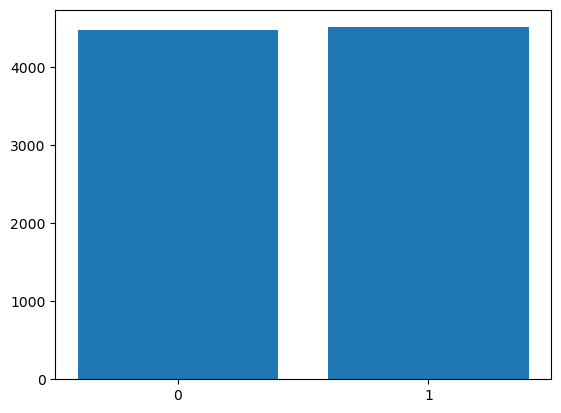

In [456]:
#The distribution of the training subset
train_distribution = Counter([label for _, label in cifar2_train])
plt.bar([str(x) for x in train_distribution.keys()], train_distribution.values())
train_distribution

In [457]:
train_targets_distribution = np.array(list(train_distribution.values()))
train_targets_distribution.mean(), train_targets_distribution.std()

(4493.5, 18.5)

The random split between train and validation kept the subset fairly balanced. A difference of 37 targets, should not impact training. An idea later could be to use smote to artificially generate more training cases.

# Creating MyMLP

In [458]:
class MyMLP(nn.Module):
    
    #Architecture
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3*32*32, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 2)
    
    #Forward pass
    def forward(self, x):
        
        #Input
        out = torch.flatten(x, 1)
        
        #Hidden layers
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        
        #Output
        out = self.fc4(out)
        
        return out
        
        

In [459]:
MyMLP

__main__.MyMLP

# Creating train func

In [553]:
#Code from 2nd tutorial. Dont think that it is necessary to rewrite it differently. 

def train(n_epochs, optimizer, model, loss_fn, train_loader):
    
    #Get number of batches, make a list for training losses, change model mode to training, and zero the gradients.
    n_batch = len(train_loader)
    losses_train = []
    losses_val = []
    model.train()
    optimizer.zero_grad(set_to_none=True)
    
    #Every epoch 
    for epoch in range(1, n_epochs + 1):
        
        loss_train = 0.0
        for imgs, labels in train_loader:

            imgs = imgs.to(device=device, dtype=torch.double) 
            labels = labels.to(device=device)

            outputs = model(imgs)
            
            loss = loss_fn(outputs, labels)
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()

            loss_train += loss.item()
            
        losses_train.append(loss_train / n_batch)

        if epoch == 1 or epoch % 10 == 0:
            print('{}  |  Epoch {}  |  Training loss {:.3f}'.format(
                datetime.now().time(), epoch, loss_train / n_batch))

    return losses_train

L2 regularization idea:
https://www.youtube.com/watch?v=_SlPBbxuqas , 
https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd

*
Momentum: https://www.youtube.com/watch?v=WNBu7CWaEDE

In [549]:
#This does not give the same output as SGD, but works better somehow
l2 = torch.tensor(0.).to(device=device) 
with torch.no_grad():
    for p in model.parameters():
        l2 += torch.norm(p)

loss += lr*l2

NameError: name 'loss' is not defined

In [716]:
def train_manual_update(n_epochs, lr, model, loss_fn, train_loader, weight_decay, momentum, dampening):
    #Get number of batches, make a list for training losses, change model mode to training, and zero the gradients.
    n_batch = len(train_loader)
    losses_train = []
    losses_val = []
    model.train()
    ms = {i: 0 for i, p in enumerate(model.parameters())}
    #Every epoch 
    for epoch in range(1, n_epochs + 1):
        
        loss_train = 0.0
        for imgs, labels in train_loader:

            imgs = imgs.to(device=device) 
            labels = labels.to(device=device)

            outputs = model(imgs)
            
            
            loss = loss_fn(outputs, labels)
            
            loss.backward()
            
           
            
            
            #Replacing the optimizer with manual update.
            #The documentation says that the parameters stores their gradient from the backward pass.
            with torch.no_grad():
                
                #For every parameter in the model
                for i, p in enumerate(model.parameters()):
                    #print(i)
                    #The updated parameter is the old - lr*grad. The p updates with copy_
                    if epoch > 1:
                        m = ms[i]*momentum + (1-dampening) * p.grad
                        ms[i] = m
                    else:
                        m = p.grad
                        ms[i] = m
                    
                    new_p = (1-lr*weight_decay)*p - lr*m
                    p.copy_(new_p)
                    
                    
                    #Crucial to zero the gradients.
                    p.grad.data.zero_()

            loss_train += loss.item()
    
            
        losses_train.append(loss_train / n_batch)

        if epoch == 1 or epoch % 10 == 0:
            print('{}  |  Epoch {}  |  Training loss {:.3f}'.format(
                datetime.now().time(), epoch, loss_train / n_batch))
    return losses_train

In [738]:
#Setting up device to train on
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))

#Creating a dataloader for the training, loss function as cross entropy.
train_loader = DataLoader(cifar2_train, batch_size=64, shuffle=False)
loss_fn = nn.CrossEntropyLoss()

#Learning rate for the comparison
lr = 1e-2

#Creating a new model with specific weights
torch.manual_seed(555)
model = MyMLP().to(device=device) 


#perform the manual update:
manual_losses = train_manual_update(
    n_epochs = 10,
    lr = lr,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    weight_decay = 0,
    momentum = 0.5,
    dampening = 0.5
)

#Creating the same model as earlier
torch.manual_seed(555)
model = MyMLP().to(device=device) 

#Default optimizer with same learning rate
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=0, momentum=0.5, dampening = 0.5) #optimizer

#Perform the 
optimizer_losses = train(
    n_epochs = 10,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

#Dampening is not working perfectly right now. There are some small errors, but are very close. 
#The first 3 decimals are identical, but from 4 and after they become different. Difference of 0.1% 
#Im unsure where the reason for this is. 

14:17:04.917133  |  Epoch 1  |  Training loss 0.628
14:17:09.156169  |  Epoch 10  |  Training loss 0.316
14:17:09.556792  |  Epoch 1  |  Training loss 0.628
14:17:13.047748  |  Epoch 10  |  Training loss 0.316


In [732]:
def check_similar_decimals(manual_losses, optimizer_losses, dec=10):
    for i in range(0, len(manual_losses)):
        print(round(manual_losses[i], dec) == round(optimizer_losses[i], dec))

In [731]:
check_similar_decimals(manual_losses, optimizer_losses, 3)

True
False
False
True
True
False
False
True
True
True


In [735]:
def check_loss_ratio(manual_losses, optimizer_losses):
    for i in range(0, len(manual_losses)):
        print(1-(manual_losses[i] / optimizer_losses[i]))

In [737]:
check_loss_ratio(manual_losses, optimizer_losses)

0.000741367152614747
0.0014852084102223717
0.001148932615665399
0.0010526628208944455
0.001028523274700488
0.0010136229333037594
0.0009143543301884938
0.0008580676118246089
0.0009208208472840651
0.0015821875095665128


In [467]:
dir(train_loader)

['_DataLoader__initialized',
 '_DataLoader__multiprocessing_context',
 '_IterableDataset_len_called',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_auto_collation',
 '_dataset_kind',
 '_get_iterator',
 '_index_sampler',
 '_is_protocol',
 '_iterator',
 'batch_sampler',
 'batch_size',
 'check_worker_number_rationality',
 'collate_fn',
 'dataset',
 'drop_last',
 'generator',
 'multiprocessing_context',
 'num_workers',
 'persistent_workers',
 'pin_memory',
 'pin_memory_device',
 'prefetch_factor',
 'sampler',
 'timeout',
 'worker_init_fn']

In [436]:
for p in model.parameters():
    print(p)

Parameter containing:
tensor([[ 4.0734e+00,  3.0396e+00,  5.8444e+00,  ..., -1.6150e+01,
         -1.4618e+01, -1.5408e+01],
        [ 1.0717e-02, -4.8639e-02, -8.4088e-02,  ..., -5.9912e-02,
         -1.2282e-01, -1.3847e-01],
        [ 6.6456e-03,  2.7555e-02,  4.2451e-02,  ..., -2.5279e-02,
          2.1497e-04, -2.8980e-02],
        ...,
        [ 5.2461e-02,  3.7352e-02,  1.0715e-02,  ...,  7.3256e-02,
          7.6021e-02,  8.0186e-02],
        [ 6.4679e+00,  4.9129e+00,  9.3686e+00,  ..., -2.5361e+01,
         -2.2956e+01, -2.4204e+01],
        [-2.2677e-03,  3.4642e-02, -3.0002e-03,  ..., -4.7635e-02,
         -6.2336e-02, -6.6213e-02]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 1.2285e+01, -2.5355e-01, -1.7659e-01, -1.1753e-01,  1.3121e+01,
        -3.0992e+00, -3.3447e-01, -3.8641e-01,  7.9750e-02, -3.7330e-01,
        -1.6120e-01,  7.0355e+00,  2.7695e+00,  1.2313e+01, -3.0269e-01,
        -1.1427e-01, -1.3601e-01,  3.0740e-01, -8.8837e-02, -1.3516e